# Reading VTK

/home/antonio/facul/TCC/acwv-postprocessing/.venv/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:36: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


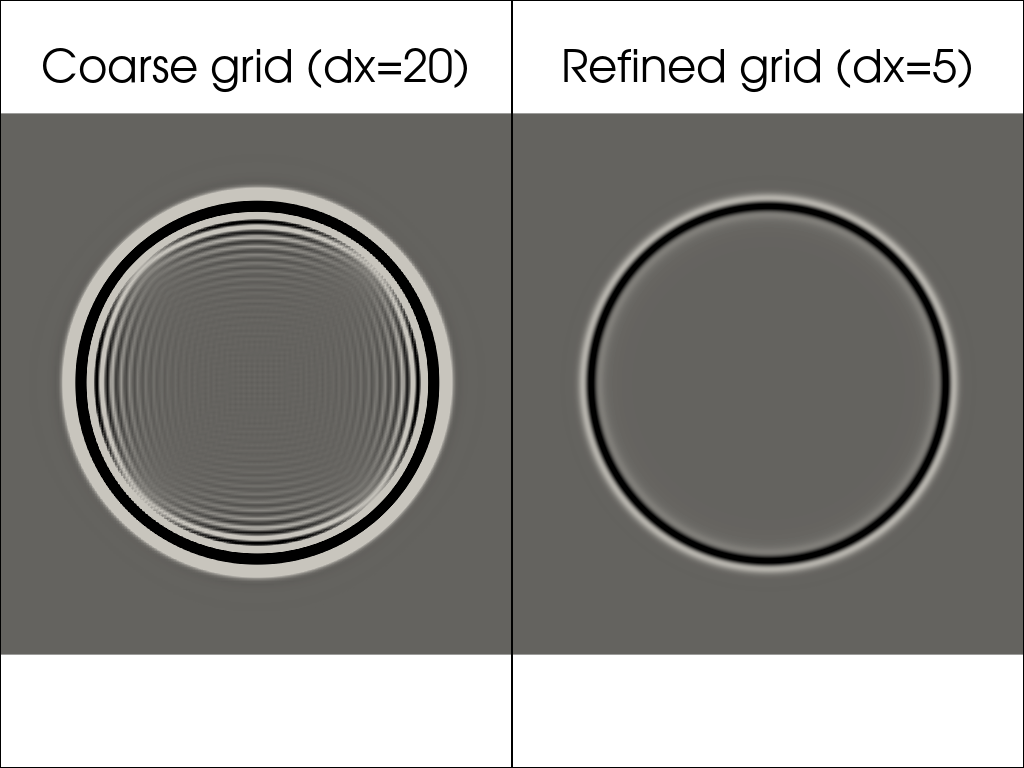

In [48]:
import pyvista as pv

coarse_grid = pv.read("./sample/coarse_grid/output_data_0_15.vti")
refined_grid = pv.read("./sample/refined_grid/output_data_0_15.vti")

plotter = pv.Plotter(shape=(1, 2), border=True)

plotter.subplot(0, 0)
plotter.add_mesh(coarse_grid, cmap="grey", clim=(-0.5, 0.5), show_scalar_bar=False)
plotter.add_title("Coarse grid (dx=20)")
plotter.view_xy()
plotter.camera.zoom(1.5)

plotter.subplot(0, 1)
plotter.add_mesh(refined_grid, cmap="grey", clim=(-0.5, 0.5), show_scalar_bar=False)
plotter.add_title("Refined grid (dx=5)")
plotter.view_xy()
plotter.camera.zoom(1.5)

plotter.show()

# pix2pix post-processing